To use `fastai.medical.imaging` you'll need to:

In [7]:
#!pip install pydicom kornia opencv-python scikit-image nbdev

In [8]:
#!pip install fastai2

In [9]:
#!pip install fastcore==0.1.35

In [10]:
# downgrade PyTorch and torchvision
!pip install torch==1.6.0 torchvision==0.7.0

In [11]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

## Download and import of X-ray DICOM files

In [12]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

The `_siimsmall` folder has the following directory/file structure:

<img src='https://docs.fast.ai/images/siim_folder_structure.jpeg'>

### What are DICOMs?
DICOM(<b>D</b>igital <b>I</b>maging and <b>CO</b>mmunications in Medicine) is the de-facto standard that establishes rules that allow medical images(X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals. The DICOM format provides a suitable means that meets health infomation exchange (HIE) standards for transmision of health related data among facilites and HL7 standards which is the messaging standard that enables clinical applications to exchange data

DICOM files typically have a .dcm extension and provides a means of storing data in separate ‘tags’ such as patient information as well as image/pixel data. A DICOM file consists of a header and image data sets packed into a single file. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc.

16 bit DICOM images have values ranging from -32768 to 32768 while 8-bit greyscale images store values from 0 to 255. The value ranges in DICOM images are useful as they correlate with the Hounsfield Scale which is a quantitative scale for describing radiodensity

### Plotting the DICOM data
To analyze our dataset, we load the paths to the DICOM files with the `get_dicom_files` function. When calling the function, we append <i>train/</i> to the `pneumothorax_source` path to choose the folder where the DICOM files are located. We store the path to each DICOM file in the items list.

In [13]:
items = get_dicom_files(pneumothorax_source/f'train/')

In [14]:
# next we split data into train/val using RandomSplitter function
trn, val = RandomSplitter()(items)

Pydicom is a python package for parsing DICOM files, making it easier to access the `header` of the DICOM as well as coverting the raw `pixel_data` into pythonic structures for easier manipulation. `fastai.medical.imaging` uses `pydicom.dcmread` to load the DICOM file.

To plot an X-ray, we can select an entry in the `items` list and load the DICOM file with `dcmread`.

In [15]:
patient = 7
xray_sample = items[patient].dcmread()

Header content:

In [16]:
xray_sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3926.1517875180.155131
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3926.1517875180.155131
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

Explanation of each element is beyond the scope of this tutorial but this [site](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1.4) has some excellent information about each of the entries.

Some key pointers on the tag information above:

- <b>Pixel Data</b> (7fe0 0010) - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first
- <b>Photometric Interpretation</b> (0028, 0004) - also known as color space. In this case it is `MONOCHROME2` where pixel data is represented as a single monochrome image plane where low values=dark, high values=bright. If the colorspace was `MONOCHROME` then the low values=bright and high values=dark info.
- <b>Samples per Pixel</b> (0028, 0002) - This should be 1 as this image is monochrome. This value would be 3 if the color space was RGB for example
Bits Stored (0028 0101) - Number of bits stored for each pixel sample. Typical 8 bit images have a pixel range between `0` and `255`
- <b>Pixel Represenation</b>(0028 0103) - can either be unsigned(0) or signed(1)
- <b>Lossy Image Compression</b> (0028 2110) - `00` image has not been subjected to lossy compression. `01` image has been subjected to lossy compression.
- <b>Lossy Image Compression Method</b> (0028 2114) - states the type of lossy compression used (in this case `ISO_10918_1` represents JPEG Lossy Compression)
- <b>Pixel Data</b> (7fe0, 0010) - Array of 161452 elements represents the image pixel data that pydicom uses to convert the pixel data into an image.

What does `PixelData` look like?

In [17]:
xray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0F\t\x02\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x01\x05\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x01\x02\x04\x05\x06\x07\x08\t\xff\xc4\x00j\x10\x00\x01\x03\x03\x03\x02\x04\x02\x06\x06\x03\x08\t\x0b\x11\t\x01\x02\x03\x11\x00\x04!\x121A\x05Q\x06\x13"a2q\x07\x08\x14\x81\x91\xa1#B\xb1\xc1\xd1\xd2\t\x15R\x16\x17$3b\x93\xb3\xe1\x184ersv\xb4'

Because of the complexity in interpreting `PixelData`, `pydicom` provides an easy way to get it in a convenient form: `pixel_array` which returns a numpy.ndarray containing the pixel data:

In [18]:
xray_sample.pixel_array, xray_sample.pixel_array.shape

(array([[ 0,  0,  0, ..., 40, 39, 34],
        [ 0,  0,  0, ..., 56, 56, 50],
        [ 0,  0,  0, ..., 46, 45, 40],
        ...,
        [ 0,  0,  0, ..., 31, 31, 33],
        [ 0,  0,  0, ..., 34, 33, 34],
        [ 0,  0,  0, ...,  3,  2,  3]], dtype=uint8), (1024, 1024))

You can then use the `show` function to view the image

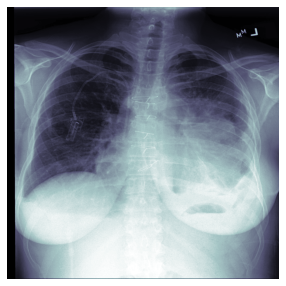

In [19]:
xray_sample.show()

You can also conveniently create a dataframe with all the `tag` information as columns for all the images in a dataset by using `from_dicoms`

In [20]:
dicom_dataframe = pd.DataFrame.from_dicoms(items)
dicom_dataframe[:5]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,PatientName,PatientID,PatientBirthDate,PatientSex,PatientAge,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,PatientOrientation,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.11360.1517875232.583238,19010101,000000.00,,CR,WSD,,view: PA,"(2, c, 9, 5, d, 2, 9, 1, -, 8, 3, 5, 6, -, 4, c, 7, b, -, b, 4, e, d, -, f, 8, 4, f, c, d, 7, 2, 6, 5, f, 6)",2c95d291-8356-4c7b-b4ed-f84fcd7265f6,,M,7,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.11360.1517875232.583237,1.2.276.0.7230010.3.1.3.8323329.11360.1517875232.583236,,1,1,,1,MONOCHROME2,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000041.dcm,1,0.139,0,249,82.044166,76.077949,0.172750
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.4669.1517875184.50463,19010101,000000.00,,CR,WSD,,view: AP,"(d, 9, 2, 5, 9, a, 3, b, -, 9, 2, 0, f, -, 4, 0, 7, c, -, 8, 1, e, f, -, 6, b, e, 0, 0, 3, b, 1, 1, c, 6, c)",d9259a3b-920f-407c-81ef-6be003b11c6c,,M,61,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.4669.1517875184.50462,1.2.276.0.7230010.3.1.3.8323329.4669.1517875184.50461,,1,1,,1,MONOCHROME2,1024,1024,0.171,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000235.dcm,1,0.171,0,226,135.040228,46.547500,0.127299
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.4350.1517875182.418199,19010101,000000.00,,CR,WSD,,view: AP,"(c, 1, 0, 4, 8, b, c, 8, -, 9, 6, 4, c, -, 4, a, 8, b, -, 9, a, 0, a, -, c, b, 5, 8, 7, 5, d, 9, 6, 0, 2, 6)",c1048bc8-964c-4a8b-9a0a-cb5875d96026,,F,54,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.4350.1517875182.418198,1.2.276.0.7230010.3.1.3.8323329.4350.1517875182.418197,,1,1,,1,MONOCHROME2,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000102.dcm,1,0.139,0,241,102.369156,50.137323,0.337895
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2372.1517875172.409638,19010101,000000.00,,CR,WSD,,view: PA,"(4, 2, f, e, 9, 0, 4, 4, -, 7, 4, 1, 8, -, 4, 2, 8, d, -, a, 3, e, a, -, 3, 2, 0, b, 0, 4, a, 7, 3, 6, 2, a)",42fe9044-7418-428d-a3ea-320b04a7362a,,F,51,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.2372.1517875172.409637,1.2.276.0.7230010.3.1.3.8323329.2372.1517875172.409636,,1,1,,1,MONOCHROME2,1024,1024,0.143,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000063.dcm,1,0.143,0,255,109.304933,67.568769,0.331700
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.32219.1517875159.70802,19010101,000000.00,,CR,WSD,,view: PA,"(9, 9, 1, 7, 1, 9, 0, 8, -, 3, 6, 6, 5, -, 4, 8, e, 8, -, 8, 2, c, 8, -, 6, 6, d, 0, 0, 9, 8, c, e, 2, 0, 9)",99171908-3665-48e8-82c8-66d0098ce209,,F,52,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.32219.1517875159.70801,1.2.276.0.7230010.3.1.3.8323329.32219.1517875159.70800,,1,1,,1,MONOCHROME2,1024,1024,0.171,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000006.dcm,1,0.171,0,255,153.405355,59.543063,0.144505


Next, we need to load the labels for the dataset. We import the labels.csv file using pandas and print the first five entries. The <b>file</b> column shows the relative path to the `.dcm` file and the label column indicates whether the chest x-ray has a pneumothorax or not.

In [21]:
df = pd.read_csv(pneumothorax_source/f'labels.csv')
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


Now, we use the `DataBlock` class to prepare the DICOM data for training.

As we are dealing with DICOM images, we need to use `PILDicom` as the `ImageBlock` category. This is so the `DataBlock` will know how to open the DICOM images. As this is a binary classification task we will use `CategoryBlock`

In [22]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=224))

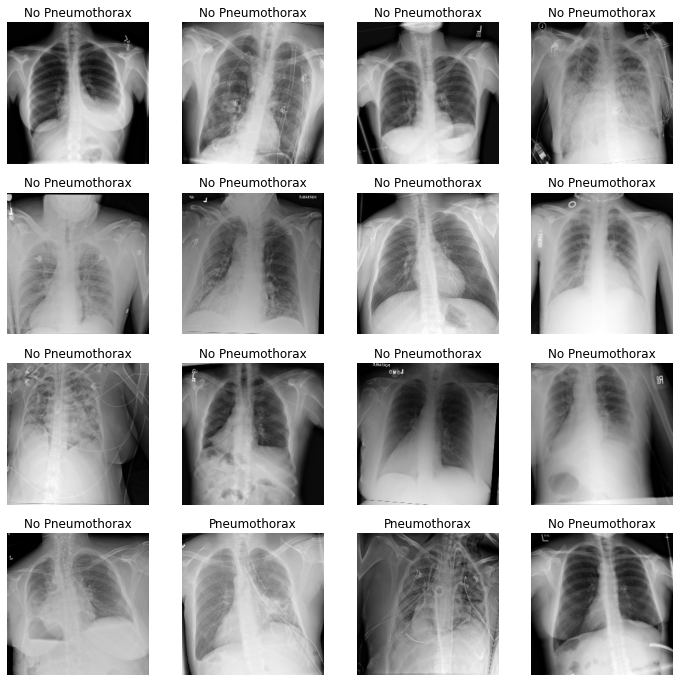

In [23]:
dls = pneumothorax.dataloaders(df.values, num_workers=0)
dls.show_batch(max_n=16)

## Training

In [24]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Note that if you do not select a loss or optimizer function, fastai will try to choose the best selection for the task. You can check the loss function by calling `loss_func`

In [25]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

And you can do the same for the optimizer by calling `opt_func`

In [26]:
learn.opt_func

<function fastai2.optimizer.Adam>

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.5848931980144698e-06)

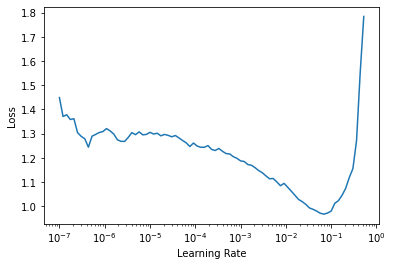

In [27]:
# find the best learning rate
learn.lr_find()

In [28]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.234804,0.525243,0.720000,00:03


In [29]:
learn.predict(pneumothorax_source/f'train/Pneumothorax/000004.dcm')

('No Pneumothorax', tensor(0), tensor([0.6660, 0.3340]))

In [30]:
# creates TTA (Test Time Augmentation)
tta = learn.tta(use_max=True)

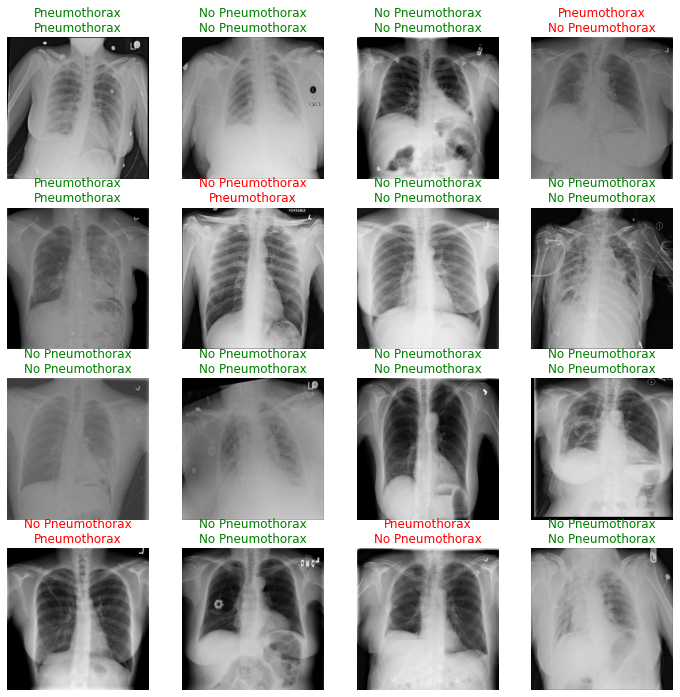

In [31]:
learn.show_results(max_n=16)

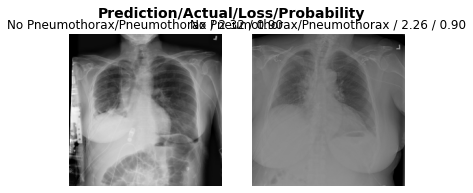

In [33]:
# interpretation
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(2)

## Result Evaluation

Medical models are predominantly high impact so it is important to know how good a model is at detecting a certain condition.

This model has an accuracy of 72%. Accuracy can be defined as the number of correctly predicted data points out of all the data points. However in this context we can define accuracy as the probability that the model is correct and the patient has the condition <b>PLUS</b> the probability that the model is correct and the patient does not have the condition.

There are some other key terms that need to be used when evaluating medical models:

**False Positive & False Negative**

- **False Positive** is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present
- **False Negative **is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present

**Sensitivity & Specificity**

- **Sensitivity or True Positive Rate** is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives
> Example: A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition

- **Specificity or True Negative Rate** is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives

**PPV and NPV**

Most medical testing is evaluated via **PPV** (Positive Predictive Value) or **NPV** (Negative Predictive Value).

**PPV** - if the model predicts a patient has a condition what is the probability that the patient actually has the condition

**NPV** - if the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

**Confusion Matrix**

The confusion matrix is plotted against the `valid` dataset

True


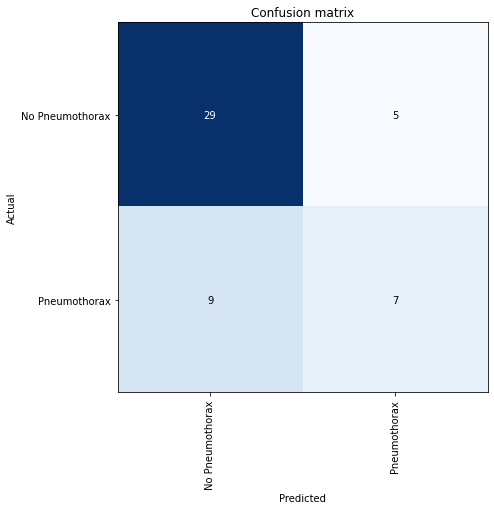

In [36]:
# use ClassificationInterpretation to plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
losses, idx = interp.top_losses()
print(len(dls.valid_ds)==len(losses)==len(idx))
interp.plot_confusion_matrix(figsize=(7,7))

You can also reproduce the results interpreted from `plot_confusion_matrix` like so:

In [37]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

29 5 9 7


Note that **Sensitivity = True Positive/(True Positive + False Negative)**

In [38]:
sensitivity = tp / (tp + fn)
sensitivity

0.4375

In this case the model has a sensitivity of 40% and hence is only capable of correctly detecting 40% True Positives (i.e. who have Pneumothorax) but will miss 60% of False Negatives (patients that actually have Pneumothorax but were told they did not! Not a good situation to be in).

This is also know as a **Type II error**

**Specificity = True Negative/(False Positive + True Negative)**

In [39]:
specificity = tn / (fp + tn)
specificity

0.8529411764705882

The model has a specificity of 63% and hence can correctly detect 85% of the time that a patient does not have Pneumothorax but will incorrectly classify that 15% of the patients have Pneumothorax (False Postive) but actually do not.

This is also known as a **Type I error**

Positive Predictive Value (PPV)

In [40]:
ppv = tp/(tp+fp)
ppv

0.5833333333333334

In this case the model performs poorly in correctly predicting patients with Pneumothorax

Negative Predictive Value (NPV)

In [41]:
npv = tn/(tn+fn)
npv

0.7631578947368421

This model is better at predicting patients with No Pneumothorax.

**Calculating Accuracy**

The accuracy of this model as mentioned before was 72% but how was this calculated? We can consider accuracy as:

accuracy = sensitivity x prevalence + specificity * (1 - prevalence) **bold text**

Where **prevalence** is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time. The prevalence in this case is how many patients in the valid dataset have the condition compared to the total number.

To view the files in the valid dataset you call `dls.valid_ds.cat`

In [42]:
val = dls.valid_ds.cat
val[0]

<bound method L.cat of TfmdLists: [['train/Pneumothorax/000129.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000115.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000127.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000034.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000204.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000102.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000042.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000237.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000160.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000054.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000032.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000083.dcm' 'Pneumothorax']
 ['train/Pneumothorax/000130.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000088.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000166.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000182.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000112.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000092.dcm' '

There are 15 Pneumothorax images in the valid set (which has a total of 50 images and can be checked by using `len(dls.valid_ds)`) so the **prevalence here is 15/50 = 0.3**

In [44]:
prevalence = 15/len(dls.valid_ds)
prevalence

0.3

In [46]:
acc = (sensitivity * prevalence) + (specificity * (1 - prevalence))
acc

0.7283088235294117